In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.autograd import Variable

In [2]:
path = '/home/daiict/CVShare/Jeni/hts/bioassay-datasets/'
p_fingerprints = []
labels = []
with open(path+'AID362red_train.csv') as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        p_fingerprints.append(row[:112])
        labels.append(row[-1])

In [3]:
p_fingerprints = np.asarray(p_fingerprints)[1:]
p_fingerprints = p_fingerprints.astype(int)
#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim) = p_fingerprints.shape
labels = labels[1:]
print(no_examples,ip_dim)
print("total no of 1s",np.sum(p_fingerprints))
print("total no of 0s",no_examples*ip_dim-np.sum(p_fingerprints))

(3423, 112)
('total no of 1s', 25982)
('total no of 0s', 357394)


In [4]:
p_fingerprints[(p_fingerprints==0)] = -1

In [5]:
labels2 = np.zeros((len(labels),1))
for i,l in enumerate(labels):
    if l=='Active':
        labels2[i] = 1
    else:
        labels2[i] = 0

In [6]:
no_active_ele = (sum(labels2))
print(no_active_ele)

[ 48.]


In [7]:
X_dim = ip_dim
h1_dim = 300
h2_dim = 200
h3_dim = 200
z_dim = 2

In [8]:
def get_train_batch(batch_size):
    samples = np.random.randint(low=0,high=no_examples,size=(batch_size,1))
    train_batch = p_fingerprints[samples].reshape(batch_size,ip_dim)
    train_batch = train_batch.astype(int)
    train_batch = torch.cuda.FloatTensor(train_batch)
    train_batch = Variable(train_batch,requires_grad=False).cuda()
    target = Variable(torch.cuda.FloatTensor(labels2[samples]),requires_grad=False)
    
    return train_batch,target

In [9]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(X_dim,h1_dim)
        self.l2 = nn.Linear(h1_dim,h2_dim)
        self.l3 = nn.Linear(h2_dim,h3_dim)
        self.l4 = nn.Linear(h3_dim,z_dim)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        
        return x

In [10]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,h3_dim)
        self.l2 = nn.Linear(h3_dim,h2_dim)
        self.l3 = nn.Linear(h2_dim,h1_dim)
        self.l4 = nn.Linear(h1_dim,X_dim)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.tanh(self.l4(x))
        
        return x

In [11]:
def train_model(Q,Q_solver,P,P_solver):
    
    for it in range(200):
        x,y = get_train_batch(120)
        z = Q(x)

        #Extra Loss
        
        '''x_diff = x.data[0].unsqueeze(0)-x.data[1].unsqueeze(0)
        z_diff = z[0].unsqueeze(0)-z[1].unsqueeze(0)

        den = torch.dot(x_diff,x_diff)
        num = torch.dot(z_diff,z_diff)

        vec = (1e3*num/den)
        extra_loss = 1e-3*torch.mul(vec,vec)
        extra_loss.backward(retain_variables = True)

        E_solver.step()
        Q.zero_grad()'''

        #Reconstruction
        
        x_recon = P(z)
        '''
        x_recon[x_recon<0] = 0
        x_recon[x_recon>0] = 1
        x_tar = Variable(torch.cuda.FloatTensor(x.size()),requires_grad=False)
        x_tar[x==-1] = 0
        x_tar[x==1] = 1'''
        
        criterion = nn.MSELoss()
        CEL = criterion(x_recon, x)
        
        CEL.backward()
        Q_solver.step()
        P_solver.step()
        
        Q.zero_grad()
        P.zero_grad()
        
        if(it%10==0):
            #print(extra_loss.data[0],CEL.data[0])
            print(CEL.data[0])
            #print(x_recon[0][:50].cpu().data.numpy().T)
            #print()
            #print(x[0][:50].cpu().data.numpy().T)
           # print()
    return Q,P

In [12]:
def generate_model():
    Q = encoder()
    Q.cuda()
    Q_solver = optim.Adam(Q.parameters(),lr=1e-4)
    E_solver = optim.Adam(Q.parameters(),lr = 1e-5)
    P = decoder()
    P.cuda()
    P_solver = optim.Adam(P.parameters(),lr = 1e-4)
    Q,P = train_model(Q,Q_solver,P,P_solver)
    
    return Q,P

In [13]:
Q,P = generate_model()

1.01278722286
0.972950935364
0.93108099699
0.863413929939
0.723329603672
0.430634737015
0.249615237117
0.221396133304
0.236529782414
0.212806299329
0.215380951762
0.203121855855
0.204277351499
0.206753909588
0.211458310485
0.190809845924
0.194185584784
0.198657050729
0.208823964
0.207674711943


In [38]:
entire_batch,batch_labels = get_train_batch(no_examples)
z_encoded = Q(entire_batch)
batch_labels_np = batch_labels.cpu().data.numpy()

x_encoded = z_encoded.cpu().data.numpy()[:,0]
y_encoded = z_encoded.cpu().data.numpy()[:,1]

In [39]:
batch_labels_np = batch_labels_np.astype(int)
print(batch_labels_np.dtype)
print(batch_labels_np.shape)
batch_labels_np = list(batch_labels_np.reshape(no_examples,1))

int64
(3423, 1, 1)
0
0
0
0
0


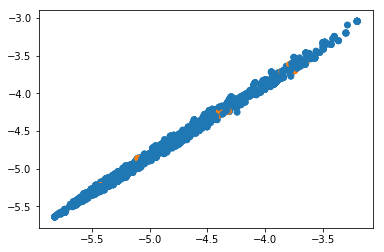

(3423,)


In [41]:
colors = []
for l in batch_labels_np:
    colors.append("C"+str(int(l)))
    
plt.scatter(x_encoded,y_encoded,c=colors)
plt.show()

print(x_encoded.shape)

In [ ]:
def sample_z(size):
    ind = torch.cuda.LongTensor(torch.randperm(no_examples)[:size].numpy())
    return z_encoded[ind], batch_labels[ind]

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.l1 = nn.Linear(z_dim,400)
        self.l2 = nn.Linear(400,400)
        self.l3 = nn.Linear(400,70)
        self.l4 = nn.Linear(70,1)
        
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x

In [ ]:
def train_disc(d,d_optim):
    for ep in range(2000):
        d_optim.zero_grad()
        x,true_l = sample_z(50)
        p_labels = d(x)
        criteria = nn.BCELoss()
        loss = criteria(p_labels,true_l)
        loss.backward(retain_variables = True)
        d_optim.step()
        
        if(ep%50==49):
            print(loss.data[0])
            
    return d
    

In [ ]:
def gen_disc_model():
    d = Discriminator()
    d.cuda()
    d_optim = optim.Adam(d.parameters(),lr=1e-4)
    d = train_disc(d,d_optim)
    return d

In [ ]:
d = gen_disc_model()

# Check on Training Data 

In [ ]:
entire_batch,batch_labels = get_train_batch(no_examples)
train_encoded = Q(entire_batch)
train_op = d(train_encoded)

In [ ]:
print(train_op.cpu().data.numpy())

In [ ]:
train_op = train_op.cpu().data.numpy()
train_op[train_op>0.5] = 1
train_op[train_op<0.5] = 0
print(sum(train_op))